## About dataset

#### https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Dataset contains 7022 images of human brain MRI images which are classified into 4 classes: 
1. glioma 
2. meningioma
3. pituitary
4. no tumor


### 1. Data analysis

In [1]:
import os, os.path
import matplotlib.pyplot as plt
import numpy as np

Let's count how many images are in train/test directories

In [2]:
train_dir = "Training"
test_dir = "Testing"

In [3]:
def countClasses(directory):
    counts = {}
    for path in os.listdir(directory):
        dirPath = os.path.join(directory, path)
        if os.path.isdir(dirPath):
            counts[path] = len([name for name in os.listdir(dirPath) 
                                if os.path.isfile(os.path.join(dirPath, name))])
        
    return counts

In [4]:
train_counts = countClasses(train_dir)
print(train_counts)

{'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339}


<BarContainer object of 4 artists>

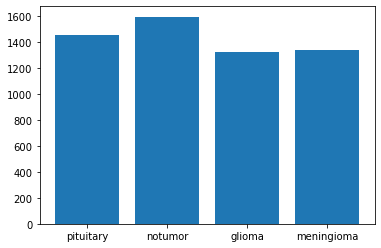

In [5]:
plt.bar(train_counts.keys(), train_counts.values())

In [6]:
test_counts = countClasses(test_dir)
print(test_counts)

{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}


<BarContainer object of 4 artists>

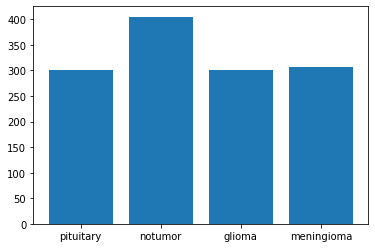

In [7]:
plt.bar(test_counts.keys(), test_counts.values())

In [8]:
train_count = sum(train_counts.values())
test_count = sum(test_counts.values())
print("Training data: ",train_count)
print("Testing data: ", test_count)

Training data:  5712
Testing data:  1311


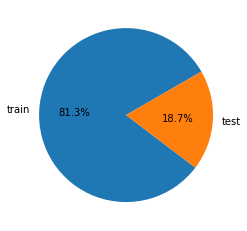

In [9]:
plt.pie([train_count, test_count], 
        labels = ["train", "test"],
        startangle = 30,
        autopct='%.1f%%')

plt.show()

### 2. Data preprocessing 

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras

batch_size = 32
img_height = 180
img_width = 180

Let's use 10% of training data as validation set.
Each image is going to be resized to 180x180 pixels

In [11]:
train_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Metal device set to: Apple M1


2022-06-06 13:12:21.046423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-06 13:12:21.046522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 571 files for validation.


As expected in single batch there are 32 images of 180x180 size

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2022-06-06 13:12:21.230292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 180, 180, 3)
(32,)


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *

The RGB values are in range of [0,255]. Let's rescale that to [0,1] range

In [15]:
resize_and_rescale = tf.keras.Sequential([
  Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  Rescaling(1./255)
])

We're going to save only the best model.
To avoid overfitting, training is ended if validation accuracy is not improving in 10 epochs 

In [16]:
from keras import callbacks

TRAINED_MODEL_DIR = "trained_models/"

model_name = TRAINED_MODEL_DIR + "model-acc-{val_accuracy:.4f}-loss-{val_loss:.4f}.hdf5"

if not os.path.exists(TRAINED_MODEL_DIR):
    os.makedirs(TRAINED_MODEL_DIR)

In [17]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),

        callbacks.ModelCheckpoint(model_name, monitor="val_loss", 
                                  verbose=1, save_best_only=True),
    ]

### 3. Creating and training models

### SVM

#### Kernels:
* RBF (Radial basis function)
* Polynomial
* Linear

Unfortunately, for svm we can't use tensorflow datasets, therefore we have to load data manually

In [18]:
labels = [
    "glioma",
    "meningioma",
    "notumor",
    "pituitary"
]

In [19]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

def loadImages(path):
    flat_data_arr=[]
    target_arr=[]
    datadir=path
    for i in labels:
        path=os.path.join(datadir,i)
        for img in os.listdir(path):
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(50,50,3))
            flat_data_arr.append(img_resized.flatten())
            target_arr.append(labels.index(i))
        print(f'loaded category:{i} successfully')

    flat_data=np.array(flat_data_arr)
    target=np.array(target_arr)
    df=pd.DataFrame(flat_data)
    df['Target']=target
    x=df.iloc[:,:-1]
    y=df.iloc[:,-1]
    
    return (x, y)

In [21]:
x_train, y_train = loadImages("Training")

loaded category:glioma successfully
loaded category:meningioma successfully
loaded category:notumor successfully
loaded category:pituitary successfully


In [22]:
x_test, y_test = loadImages("Testing")

loaded category:glioma successfully
loaded category:meningioma successfully
loaded category:notumor successfully
loaded category:pituitary successfully


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform, randint

pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC(kernel="rbf"))])

param_distribution = {
    'classifier__C': uniform(0.001, 1),
    'classifier__gamma': uniform(0.001,1)
}

rand1 = RandomizedSearchCV(pipe,
                           param_distributions=param_distribution)

rand1.fit(x_train, y_train)
rand1.best_params_

{'classifier__C': 0.8677297284465021, 'classifier__gamma': 0.5201571989678568}

In [25]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC(kernel="poly"))])

param_distribution2 = {
    'classifier__degree': randint(1,6),
    'classifier__coef0': randint(0,1),
    'classifier__C': randint(1,100),
}

rand2 = RandomizedSearchCV(pipe,
                           param_distributions=param_distribution2,
                           n_iter=5)

rand2.fit(x_train, y_train)
rand2.best_params_

{'classifier__C': 97, 'classifier__coef0': 0, 'classifier__degree': 3}

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)

pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC(kernel="linear"))])

param_grid = {
    'classifier__C': [0.00001, 0.0001, 0.01, 0.1]
}

grid = GridSearchCV(pipe, 
                      param_grid, 
                      cv=kfold, 
                      return_train_score=True)

grid.fit(x_train, y_train)
grid.best_params_

{'classifier__C': 0.01}

In [36]:
from sklearn import metrics
import matplotlib.pyplot as plt

models = []
models.append(('SVM rbf', rand1.best_estimator_))
models.append(('SVM poly', rand2.best_estimator_))
models.append(('SVM linear', grid.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    prediction = model.predict(x_test)
    precision_score.append(metrics.precision_score(y_test, prediction, average='weighted'))
    recall_score.append(metrics.recall_score(y_test, prediction, average='weighted'))
    f1_score.append( metrics.f1_score(y_test, prediction, average='weighted'))
    accuracy_score.append(metrics.accuracy_score(y_test, prediction))

/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','SVM poly', 'SVM linear'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM rbf,0.613994,0.498093,0.463308,0.498093
1,SVM poly,0.971642,0.971777,0.971631,0.971777
2,SVM linear,0.916021,0.916857,0.916374,0.916857


Let's export svm models

In [38]:
import joblib

joblib.dump(rand1.best_estimator_, 'trained_models/svm_rbf.joblib')
joblib.dump(rand2.best_estimator_, 'trained_models/svm_poly.joblib')
joblib.dump(grid.best_estimator_, 'trained_models/svm_linear.joblib')

['trained_models/svm_linear.joblib']

### Neural networks

First, let's create simple network with one Dense layer

In [399]:
import numpy as np
from keras import Sequential
from keras import optimizers

num_classes = 4

modelFlatten = Sequential([
    resize_and_rescale,
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

modelFlatten.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",
  metrics=['accuracy'])

In [400]:
modelFlatten.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_4 (Flatten)         (None, 97200)             0         
                                                                 
 dense_6 (Dense)             (None, 4)                 388804    
                                                                 
 activation_19 (Activation)  (None, 4)                 0         
                                                                 
Total params: 388,804
Trainable params: 388,804
Non-trainable params: 0
_________________________________________________________________


In [401]:
from keras.callbacks import History

history = modelFlatten.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=create_callbacks(),
    shuffle=True
)

Epoch 1/30
  1/161 [..............................] - ETA: 41s - loss: 1.4673 - accuracy: 0.2188

2022-06-01 10:04:33.808390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.7138 - accuracy: 0.6347

2022-06-01 10:04:37.387485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.32137, saving model to trained_models/model-acc-0.7128-loss-1.3214.hdf5
161/161 [==============================] - 4s 25ms/step - loss: 1.7138 - accuracy: 0.6347 - val_loss: 1.3214 - val_accuracy: 0.7128
Epoch 2/30
161/161 [==============================] - ETA: 0s - loss: 1.1036 - accuracy: 0.7360
Epoch 00002: val_loss improved from 1.32137 to 0.77474, saving model to trained_models/model-acc-0.8109-loss-0.7747.hdf5
161/161 [==============================] - 3s 21ms/step - loss: 1.1036 - accuracy: 0.7360 - val_loss: 0.7747 - val_accuracy: 0.8109
Epoch 3/30
161/161 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.7751
Epoch 00003: val_loss did not improve from 0.77474
161/161 [==============================] - 3s 21ms/step - loss: 0.9100 - accuracy: 0.7751 - val_loss: 1.0535 - val_accuracy: 0.7741
Epoch 4/30
158/161 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.8303
Epoch 00004: val_loss did 

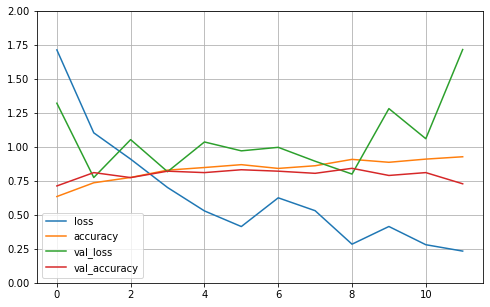

In [402]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

#### Deep neural networks

In [403]:
modelFlattenBatchNormalization = Sequential([
    resize_and_rescale,
    Flatten(),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(300, activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(100, activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(num_classes),
    Activation("softmax")
])

In [404]:
modelFlattenBatchNormalization.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",
  metrics=['accuracy'])

In [405]:
modelFlattenBatchNormalization.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_5 (Flatten)         (None, 97200)             0         
                                                                 
 batch_normalization_15 (Bat  (None, 97200)            388800    
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 97200)             0         
                                                                 
 dropout_15 (Dropout)        (None, 97200)             0         
                                                                 
 dense_7 (Dense)             (None, 300)               29160300  
                                                      

In [406]:
history = modelFlattenBatchNormalization.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=create_callbacks(),
    shuffle=True
)

Epoch 1/30


2022-06-01 10:05:15.876386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8831 - accuracy: 0.6724

2022-06-01 10:05:29.866675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.09091, saving model to trained_models/model-acc-0.6252-loss-1.0909.hdf5
161/161 [==============================] - 16s 92ms/step - loss: 0.8831 - accuracy: 0.6724 - val_loss: 1.0909 - val_accuracy: 0.6252
Epoch 2/30
161/161 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7926
Epoch 00002: val_loss improved from 1.09091 to 0.75799, saving model to trained_models/model-acc-0.7688-loss-0.7580.hdf5
161/161 [==============================] - 14s 89ms/step - loss: 0.5846 - accuracy: 0.7926 - val_loss: 0.7580 - val_accuracy: 0.7688
Epoch 3/30
161/161 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.8362
Epoch 00003: val_loss improved from 0.75799 to 0.47333, saving model to trained_models/model-acc-0.8546-loss-0.4733.hdf5
161/161 [==============================] - 14s 88ms/step - loss: 0.4630 - accuracy: 0.8362 - val_loss: 0.4733 - val_accuracy: 0.8546
Epoch 4/30
161/161 [=============================

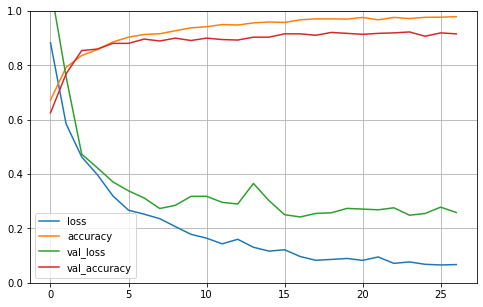

In [407]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Convolutional neural networks

In [408]:
modelConv1 = Sequential([
    resize_and_rescale,
    Conv2D(32, (3,3), padding="same", activation="relu"),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(2),
    
    Conv2D(128, 3, padding="same", activation="relu"),
    Conv2D(256, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(num_classes),
    Activation("softmax")
])

In [409]:
modelConv1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

In [410]:
modelConv1.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

In [411]:
history2 = modelConv1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=create_callbacks(),
    shuffle=True
)

Epoch 1/50


2022-06-01 10:11:50.913746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.1086 - accuracy: 0.4841

2022-06-01 10:12:46.287318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.01135, saving model to trained_models/model-acc-0.5972-loss-1.0114.hdf5
161/161 [==============================] - 58s 356ms/step - loss: 1.1086 - accuracy: 0.4841 - val_loss: 1.0114 - val_accuracy: 0.5972
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6826
Epoch 00002: val_loss improved from 1.01135 to 0.80975, saving model to trained_models/model-acc-0.6532-loss-0.8097.hdf5
161/161 [==============================] - 59s 367ms/step - loss: 0.8212 - accuracy: 0.6826 - val_loss: 0.8097 - val_accuracy: 0.6532
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.7213
Epoch 00003: val_loss improved from 0.80975 to 0.61411, saving model to trained_models/model-acc-0.7408-loss-0.6141.hdf5
161/161 [==============================] - 65s 401ms/step - loss: 0.6891 - accuracy: 0.7213 - val_loss: 0.6141 - val_accuracy: 0.7408
Epoch 4/50
161/161 [==========================

Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9432
Epoch 00027: val_loss did not improve from 0.24824
161/161 [==============================] - 76s 469ms/step - loss: 0.1566 - accuracy: 0.9432 - val_loss: 0.2516 - val_accuracy: 0.8949
Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9370
Epoch 00028: val_loss did not improve from 0.24824
161/161 [==============================] - 74s 460ms/step - loss: 0.1732 - accuracy: 0.9370 - val_loss: 0.2935 - val_accuracy: 0.8967
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9471
Epoch 00029: val_loss did not improve from 0.24824
161/161 [==============================] - 73s 455ms/step - loss: 0.1502 - accuracy: 0.9471 - val_loss: 0.3247 - val_accuracy: 0.8564
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9514
Epoch 00030: val_loss did not improve from 0.24824
161/16

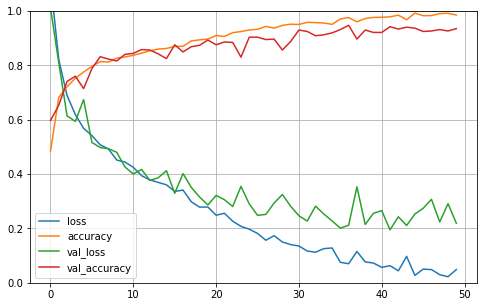

In [412]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [413]:
modelConv2 = Sequential([
    resize_and_rescale,
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(32, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(256, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

modelConv2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 90, 90, 32)       

In [414]:
modelConv2.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

In [415]:
history3 = modelConv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=create_callbacks(),
    shuffle=True
)

Epoch 1/50


2022-06-01 11:13:19.115240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.6993

2022-06-01 11:13:59.067295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.38596, saving model to trained_models/model-acc-0.3012-loss-1.3860.hdf5
161/161 [==============================] - 42s 249ms/step - loss: 0.8582 - accuracy: 0.6993 - val_loss: 1.3860 - val_accuracy: 0.3012
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.8070
Epoch 00002: val_loss improved from 1.38596 to 1.35616, saving model to trained_models/model-acc-0.3012-loss-1.3562.hdf5
161/161 [==============================] - 36s 225ms/step - loss: 0.5385 - accuracy: 0.8070 - val_loss: 1.3562 - val_accuracy: 0.3012
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8570
Epoch 00003: val_loss improved from 1.35616 to 1.19628, saving model to trained_models/model-acc-0.4413-loss-1.1963.hdf5
161/161 [==============================] - 35s 215ms/step - loss: 0.4107 - accuracy: 0.8570 - val_loss: 1.1963 - val_accuracy: 0.4413
Epoch 4/50
161/161 [==========================

Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9842
Epoch 00028: val_loss did not improve from 0.16705
161/161 [==============================] - 46s 284ms/step - loss: 0.0491 - accuracy: 0.9842 - val_loss: 0.5913 - val_accuracy: 0.7828
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9870
Epoch 00029: val_loss did not improve from 0.16705
161/161 [==============================] - 46s 283ms/step - loss: 0.0380 - accuracy: 0.9870 - val_loss: 0.7408 - val_accuracy: 0.8284
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9839
Epoch 00030: val_loss did not improve from 0.16705
161/161 [==============================] - 46s 285ms/step - loss: 0.0483 - accuracy: 0.9839 - val_loss: 0.2298 - val_accuracy: 0.9299
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9858
Epoch 00031: val_loss did not improve from 0.16705
161/16

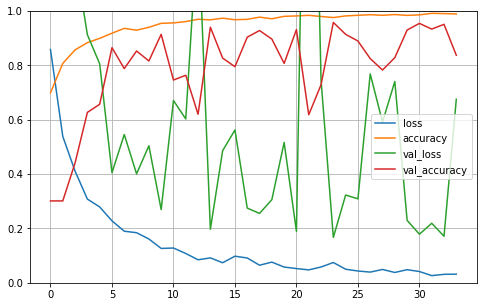

In [416]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Tuning hyperparameters using keras-tuner

In [417]:
from tensorflow.keras.optimizers import Adam

In [418]:
import keras_tuner as kt

In [419]:
def create_model(hp):
    
    hp_dropout = hp.Float('dropout', 0.1, 0.4, step=0.1)
    
    model = Sequential([
        resize_and_rescale,
        Conv2D(32, (3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Conv2D(32, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Conv2D(64, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Conv2D(64, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Conv2D(128, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Conv2D(256, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling2D((2,2)),
        Dropout(hp_dropout),

        Flatten(),
        Dense(num_classes),
        Activation("softmax")
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(hp_learning_rate),
        loss="SparseCategoricalCrossentropy",  
        metrics=['accuracy']
    )
    
    return model

In [420]:
_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Hyperband is an optimized version of random search
* hyperband paper: https://jmlr.org/papers/volume18/16-558/16-558.pdf

In [421]:
tuner = kt.Hyperband(create_model,
                     objective=("val_accuracy"),
                     max_epochs=50,
                     directory='hyperband',
                     project_name='tuner')

In [422]:
tuner.search(train_ds, validation_data=val_ds, epochs=50, shuffle=True, callbacks=[_callbacks])

Trial 12 Complete [00h 01m 53s]
val_accuracy: 0.24343256652355194

Best val_accuracy So Far: 0.7443082332611084
Total elapsed time: 00h 22m 02s


In [423]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [424]:
tuner.results_summary(num_trials=1)

Results summary
Results in hyperband/tuner
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.7443082332611084


Let's find out what is the best number of epochs

In [426]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, validation_data=val_ds, epochs=50, shuffle=True)

val_accuracy_per_epoch = history.history['val_accuracy']
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


2022-06-01 12:04:16.681382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.7001

2022-06-01 12:05:08.086722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 55s 330ms/step - loss: 1.0358 - accuracy: 0.7001 - val_loss: 1.1707 - val_accuracy: 0.4799
Epoch 2/50
161/161 [==============================] - 55s 336ms/step - loss: 0.5283 - accuracy: 0.8244 - val_loss: 0.7460 - val_accuracy: 0.6760
Epoch 3/50
161/161 [==============================] - 58s 355ms/step - loss: 0.3931 - accuracy: 0.8617 - val_loss: 0.8378 - val_accuracy: 0.7461
Epoch 4/50
161/161 [==============================] - 56s 343ms/step - loss: 0.3521 - accuracy: 0.8794 - val_loss: 0.3358 - val_accuracy: 0.8897
Epoch 5/50
161/161 [==============================] - 57s 351ms/step - loss: 0.2683 - accuracy: 0.9094 - val_loss: 0.3199 - val_accuracy: 0.8792
Epoch 6/50
161/161 [==============================] - 52s 319ms/step - loss: 0.1989 - accuracy: 0.9308 - val_loss: 0.2762 - val_accuracy: 0.9124
Epoch 7/50
161/161 [==============================] - 50s 310ms/step - loss: 0.1855 - accuracy: 0.9348 - val_loss: 1.4439 - val_accuracy: 0.7

Now retrain the model with best number of epochs

In [451]:
hypermodel = tuner.hypermodel.build(best_hps)

history4 = hypermodel.fit(train_ds, validation_data=val_ds, epochs=best_epoch, shuffle=True)

Epoch 1/42


2022-06-01 13:33:50.114482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.1484 - accuracy: 0.6625

2022-06-01 13:34:24.709810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 37s 220ms/step - loss: 1.1484 - accuracy: 0.6625 - val_loss: 0.8214 - val_accuracy: 0.6778
Epoch 2/42
161/161 [==============================] - 34s 211ms/step - loss: 0.5902 - accuracy: 0.8096 - val_loss: 0.7134 - val_accuracy: 0.7356
Epoch 3/42
161/161 [==============================] - 34s 210ms/step - loss: 0.3537 - accuracy: 0.8763 - val_loss: 0.4839 - val_accuracy: 0.8319
Epoch 4/42
161/161 [==============================] - 38s 235ms/step - loss: 0.2943 - accuracy: 0.8969 - val_loss: 0.3051 - val_accuracy: 0.8967
Epoch 5/42
161/161 [==============================] - 35s 216ms/step - loss: 0.2418 - accuracy: 0.9107 - val_loss: 0.3473 - val_accuracy: 0.9002
Epoch 6/42
161/161 [==============================] - 36s 223ms/step - loss: 0.2312 - accuracy: 0.9177 - val_loss: 0.3177 - val_accuracy: 0.9002
Epoch 7/42
161/161 [==============================] - 35s 214ms/step - loss: 0.1957 - accuracy: 0.9286 - val_loss: 0.2387 - val_accuracy: 0.9

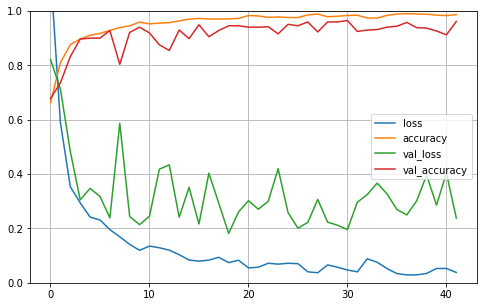

In [452]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [453]:
hypermodel.save("trained_models/hypermodel.hdf5")

In [454]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

41/41 [==============================] - 3s 77ms/step - loss: 0.2035 - accuracy: 0.9535
[test loss, test accuracy]: [0.2035461962223053, 0.9534706473350525]


#### Transfer learning

In [476]:
from keras.applications.vgg16 import VGG16

_VGG16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(img_height,img_width,3))

modelVGG16_1 = Sequential([
    _VGG16,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes),
    Activation("softmax")
])

modelVGG16_1.layers[0].trainable = False

modelVGG16_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               3277056   
                                                                 
 dense_10 (Dense)            (None, 4)                 1028      
                                                                 
 activation_37 (Activation)  (None, 4)                 0         
                                                                 
Total params: 17,992,772
Trainable params: 3,278,084
Non-trainable params: 14,714,688
_________________________________________________________________


In [477]:
modelVGG16_1.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

history5 = modelVGG16_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/30


2022-06-01 14:15:39.923041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 3.4308 - accuracy: 0.8413

2022-06-01 14:16:48.281655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 78s 480ms/step - loss: 3.4308 - accuracy: 0.8413 - val_loss: 0.5422 - val_accuracy: 0.9019
Epoch 2/30
161/161 [==============================] - 87s 539ms/step - loss: 0.1762 - accuracy: 0.9560 - val_loss: 0.4222 - val_accuracy: 0.9299
Epoch 3/30
161/161 [==============================] - 133s 829ms/step - loss: 0.0883 - accuracy: 0.9770 - val_loss: 0.4048 - val_accuracy: 0.9299
Epoch 4/30
161/161 [==============================] - 114s 710ms/step - loss: 0.0438 - accuracy: 0.9868 - val_loss: 0.4720 - val_accuracy: 0.9282
Epoch 5/30
161/161 [==============================] - 112s 694ms/step - loss: 0.0683 - accuracy: 0.9815 - val_loss: 0.5181 - val_accuracy: 0.9229
Epoch 6/30
161/161 [==============================] - 116s 723ms/step - loss: 0.0822 - accuracy: 0.9784 - val_loss: 0.3813 - val_accuracy: 0.9405
Epoch 7/30
161/161 [==============================] - 122s 761ms/step - loss: 0.0485 - accuracy: 0.9879 - val_loss: 0.4458 - val_accuracy

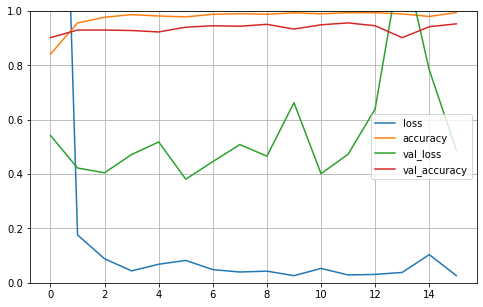

In [478]:
pd.DataFrame(history5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Model evaluation

Let's evaluate all saved models on test set

In [17]:
test_ds = image_dataset_from_directory(
  "Testing/",
  image_size=(img_height, img_width),
  shuffle=False)

Found 1311 files belonging to 4 classes.


In [20]:
trained_models = {}

for filename in os.listdir(TRAINED_MODEL_DIR):
    f = os.path.join(TRAINED_MODEL_DIR, filename)
    if "hdf5" in f:
        trained_models[filename] = f

In [21]:
trained_models = {k: v for k, v in sorted(trained_models.items(), key=lambda item: item[1])}
trained_models

{'hypermodel.hdf5': 'trained_models/hypermodel.hdf5',
 'model-acc-0.3012-loss-1.3562.hdf5': 'trained_models/model-acc-0.3012-loss-1.3562.hdf5',
 'model-acc-0.3012-loss-1.3860.hdf5': 'trained_models/model-acc-0.3012-loss-1.3860.hdf5',
 'model-acc-0.4413-loss-1.1963.hdf5': 'trained_models/model-acc-0.4413-loss-1.1963.hdf5',
 'model-acc-0.5972-loss-1.0114.hdf5': 'trained_models/model-acc-0.5972-loss-1.0114.hdf5',
 'model-acc-0.6252-loss-1.0909.hdf5': 'trained_models/model-acc-0.6252-loss-1.0909.hdf5',
 'model-acc-0.6270-loss-0.9129.hdf5': 'trained_models/model-acc-0.6270-loss-0.9129.hdf5',
 'model-acc-0.6532-loss-0.8097.hdf5': 'trained_models/model-acc-0.6532-loss-0.8097.hdf5',
 'model-acc-0.6567-loss-0.8057.hdf5': 'trained_models/model-acc-0.6567-loss-0.8057.hdf5',
 'model-acc-0.7128-loss-1.3214.hdf5': 'trained_models/model-acc-0.7128-loss-1.3214.hdf5',
 'model-acc-0.7408-loss-0.6141.hdf5': 'trained_models/model-acc-0.7408-loss-0.6141.hdf5',
 'model-acc-0.7601-loss-0.5940.hdf5': 'trained

In [22]:
for name, path in trained_models.items():
    print("------------")
    print(name)
    model = keras.models.load_model(path)
    model.evaluate(test_ds)

------------
hypermodel.hdf5


2022-06-01 15:28:04.330589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 3s 54ms/step - loss: 0.2035 - accuracy: 0.9535
------------
model-acc-0.3012-loss-1.3562.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 1.3959 - accuracy: 0.0000e+00

2022-06-01 15:28:07.556191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 50ms/step - loss: 1.3568 - accuracy: 0.3074
------------
model-acc-0.3012-loss-1.3860.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 1.3876 - accuracy: 0.0000e+00

2022-06-01 15:28:09.881043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 52ms/step - loss: 1.3859 - accuracy: 0.3089
------------
model-acc-0.4413-loss-1.1963.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 1.1097 - accuracy: 0.5312

2022-06-01 15:28:12.252888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 51ms/step - loss: 1.1892 - accuracy: 0.4561
------------
model-acc-0.5972-loss-1.0114.hdf5


2022-06-01 15:28:14.511356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 98ms/step - loss: 1.1828 - accuracy: 0.5080
------------
model-acc-0.6252-loss-1.0909.hdf5


2022-06-01 15:28:19.159918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 1.1016 - accuracy: 0.6018
------------
model-acc-0.6270-loss-0.9129.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.8364 - accuracy: 0.6406

2022-06-01 15:28:21.105951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 51ms/step - loss: 0.9303 - accuracy: 0.6171
------------
model-acc-0.6532-loss-0.8097.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.9402 - accuracy: 0.4375

2022-06-01 15:28:23.365773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 103ms/step - loss: 0.9839 - accuracy: 0.5454
------------
model-acc-0.6567-loss-0.8057.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.8002 - accuracy: 0.7344

2022-06-01 15:28:27.842830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 50ms/step - loss: 0.8359 - accuracy: 0.6377
------------
model-acc-0.7128-loss-1.3214.hdf5
 8/41 [====>.........................] - ETA: 0s - loss: 0.7871 - accuracy: 0.6797

2022-06-01 15:28:29.997379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 14ms/step - loss: 1.5942 - accuracy: 0.6629
------------
model-acc-0.7408-loss-0.6141.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.4316 - accuracy: 0.9375

2022-06-01 15:28:30.732671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 106ms/step - loss: 0.7187 - accuracy: 0.7010
------------
model-acc-0.7601-loss-0.5940.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.5421 - accuracy: 0.8438

2022-06-01 15:28:35.210681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 102ms/step - loss: 0.7044 - accuracy: 0.7239
------------
model-acc-0.7688-loss-0.7580.hdf5
 3/41 [=>............................] - ETA: 1s - loss: 0.7125 - accuracy: 0.8229

2022-06-01 15:28:39.863751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 39ms/step - loss: 0.8100 - accuracy: 0.7346
------------
model-acc-0.7881-loss-0.5166.hdf5
 1/41 [..............................] - ETA: 8s - loss: 0.5222 - accuracy: 0.7500

2022-06-01 15:28:41.657461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 100ms/step - loss: 0.5876 - accuracy: 0.7574
------------
model-acc-0.8109-loss-0.7747.hdf5
 7/41 [====>.........................] - ETA: 0s - loss: 0.2859 - accuracy: 0.9018

2022-06-01 15:28:45.907263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 16ms/step - loss: 0.8934 - accuracy: 0.8024
------------
model-acc-0.8161-loss-0.4800.hdf5
 1/41 [..............................] - ETA: 8s - loss: 1.1274 - accuracy: 0.4688

2022-06-01 15:28:46.738722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 100ms/step - loss: 0.5738 - accuracy: 0.7643
------------
model-acc-0.8231-loss-0.4934.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.5151 - accuracy: 0.7812

2022-06-01 15:28:51.028895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 98ms/step - loss: 0.5669 - accuracy: 0.7704
------------
model-acc-0.8319-loss-0.4977.hdf5
 1/41 [..............................] - ETA: 8s - loss: 0.6242 - accuracy: 0.7500

2022-06-01 15:28:55.228658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 99ms/step - loss: 0.6228 - accuracy: 0.7803
------------
model-acc-0.8406-loss-0.4258.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.6187 - accuracy: 0.7188

2022-06-01 15:28:59.456401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 97ms/step - loss: 0.4930 - accuracy: 0.8024
------------
model-acc-0.8441-loss-0.4005.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.4372 - accuracy: 0.7500

2022-06-01 15:29:03.601052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 97ms/step - loss: 0.4566 - accuracy: 0.8085
------------
model-acc-0.8529-loss-0.4007.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.1500 - accuracy: 0.9531

2022-06-01 15:29:07.833355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 51ms/step - loss: 0.4192 - accuracy: 0.8444
------------
model-acc-0.8546-loss-0.4733.hdf5
 3/41 [=>............................] - ETA: 1s - loss: 0.4556 - accuracy: 0.8542 

2022-06-01 15:29:10.858357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 37ms/step - loss: 0.5323 - accuracy: 0.8291
------------
model-acc-0.8564-loss-0.3768.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.4089 - accuracy: 0.7500

2022-06-01 15:29:12.525431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 96ms/step - loss: 0.4229 - accuracy: 0.8360
------------
model-acc-0.8599-loss-0.4230.hdf5
 3/41 [=>............................] - ETA: 1s - loss: 0.4192 - accuracy: 0.8229

2022-06-01 15:29:16.955980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.4545 - accuracy: 0.8558
------------
model-acc-0.8651-loss-0.4050.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.5796 - accuracy: 0.7656

2022-06-01 15:29:18.679828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 50ms/step - loss: 0.4587 - accuracy: 0.8352
------------
model-acc-0.8739-loss-0.3156.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.6079 - accuracy: 0.6875

2022-06-01 15:29:20.900429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 96ms/step - loss: 0.3935 - accuracy: 0.8658
------------
model-acc-0.8757-loss-0.3293.hdf5
 1/41 [..............................] - ETA: 6s - loss: 0.5763 - accuracy: 0.7188

2022-06-01 15:29:25.007152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 96ms/step - loss: 0.4132 - accuracy: 0.8421
------------
model-acc-0.8809-loss-0.3382.hdf5
 3/41 [=>............................] - ETA: 1s - loss: 0.3652 - accuracy: 0.8438

2022-06-01 15:29:29.340749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.4024 - accuracy: 0.8726
------------
model-acc-0.8809-loss-0.3712.hdf5
 3/41 [=>............................] - ETA: 1s - loss: 0.3216 - accuracy: 0.8854

2022-06-01 15:29:31.281642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.4439 - accuracy: 0.8680
------------
model-acc-0.8844-loss-0.2809.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.1575 - accuracy: 0.9375

2022-06-01 15:29:32.923680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 96ms/step - loss: 0.3253 - accuracy: 0.8871
------------
model-acc-0.8897-loss-0.2733.hdf5
 1/41 [..............................] - ETA: 6s - loss: 0.3775 - accuracy: 0.8750

2022-06-01 15:29:37.341525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 37ms/step - loss: 0.3560 - accuracy: 0.9077
------------
model-acc-0.8932-loss-0.2865.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.6515 - accuracy: 0.6562

2022-06-01 15:29:39.050533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 101ms/step - loss: 0.3606 - accuracy: 0.8741
------------
model-acc-0.8967-loss-0.3120.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.3371 - accuracy: 0.9375

2022-06-01 15:29:43.612113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.3495 - accuracy: 0.9039
------------
model-acc-0.9037-loss-0.2482.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.2315 - accuracy: 0.9375

2022-06-01 15:29:45.301068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 98ms/step - loss: 0.2887 - accuracy: 0.9016
------------
model-acc-0.9142-loss-0.2695.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.2352 - accuracy: 0.8750

2022-06-01 15:29:49.562069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 49ms/step - loss: 0.2953 - accuracy: 0.8932
------------
model-acc-0.9159-loss-0.2423.hdf5
 1/41 [..............................] - ETA: 6s - loss: 0.2895 - accuracy: 0.8750

2022-06-01 15:29:52.095434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 37ms/step - loss: 0.2635 - accuracy: 0.9397
------------
model-acc-0.9159-loss-0.2505.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.1208 - accuracy: 1.0000

2022-06-01 15:29:54.132147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 37ms/step - loss: 0.2379 - accuracy: 0.9367
------------
model-acc-0.9247-loss-0.2272.hdf5


2022-06-01 15:29:55.832305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 99ms/step - loss: 0.2714 - accuracy: 0.9130
------------
model-acc-0.9299-loss-0.2465.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.4393 - accuracy: 0.8125

2022-06-01 15:30:00.143181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 97ms/step - loss: 0.3230 - accuracy: 0.8986
------------
model-acc-0.9317-loss-0.1891.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.3530 - accuracy: 0.8438

2022-06-01 15:30:04.377148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 50ms/step - loss: 0.2007 - accuracy: 0.9252
------------
model-acc-0.9317-loss-0.2010.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.1023 - accuracy: 0.9688

2022-06-01 15:30:06.630095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 97ms/step - loss: 0.2073 - accuracy: 0.9474
------------
model-acc-0.9405-loss-0.1970.hdf5
 2/41 [>.............................] - ETA: 2s - loss: 0.2297 - accuracy: 0.8906

2022-06-01 15:30:10.863634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 50ms/step - loss: 0.1687 - accuracy: 0.9481
------------
model-acc-0.9422-loss-0.1949.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.1799 - accuracy: 0.9375

2022-06-01 15:30:13.115150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 98ms/step - loss: 0.2245 - accuracy: 0.9497


As we can see the tuned model with convolutional layers, batch normalization and dropout achieved the highest accuracy. Let's take it for further evaluation

In [23]:
best_model = keras.models.load_model('trained_models/hypermodel.hdf5')
best_model.evaluate(test_ds)

 2/41 [>.............................] - ETA: 2s - loss: 0.1792 - accuracy: 0.9219

2022-06-01 15:30:17.720595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 49ms/step - loss: 0.2035 - accuracy: 0.9535


[0.2035461962223053, 0.9534706473350525]

Confusion matrix

In [24]:
predictions = best_model.predict(test_ds)
predictions = np.argmax(predictions, axis=-1)
predictions

2022-06-01 15:30:19.858337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([0, 0, 0, ..., 3, 3, 3])

In [25]:
# class labels
target_labels = np.concatenate([y for x, y in test_ds])
target_labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [26]:
from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predictions)

In [27]:
labels = [
    "glioma",
    "meningioma",
    "notumor",
    "pituitary"
]

In [28]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

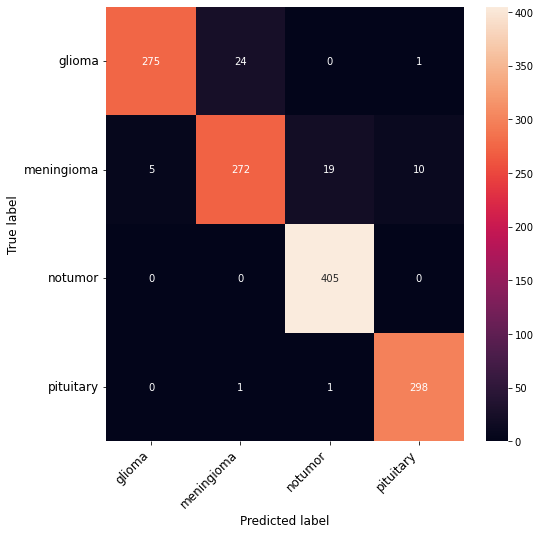

In [29]:
plot_confusion_matrix(conf, labels)

In [30]:
print(metrics.classification_report(target_labels, predictions, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.92      0.89      0.90       306
     notumor       0.95      1.00      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



### Conversion to CoreML format

In [31]:
import coremltools as ct

/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [32]:
labels = [
    "glioma",
    "meningioma",
    "notumor",
    "pituitary"
]

In [33]:
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *

In [34]:
config = ct.ClassifierConfig(labels)

coreml_model = ct.convert(best_model, 
                          inputs=[ct.ImageType()],
                         classifier_config=config)

2022-06-01 15:30:23.095740: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-06-01 15:30:23.095810: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-06-01 15:30:23.095954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 15:30:23.095965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-01 15:30:23.096753: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

In [474]:
print(coreml_model)

input {
  name: "sequential_5_input"
  type {
    imageType {
      width: 180
      height: 180
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 180
          upperBound: 180
        }
        heightRange {
          lowerBound: 180
          upperBound: 180
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "Identity"
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.7.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}



In [475]:
coreml_model.save("TumorClassifierTuned.mlmodel")